### Algoritmo de búsqueda A* (https://youtu.be/-ZEz1x10WKM)

Publicado en 1968 por Peter Hart y Bertram Raphael el algoritmo A* es uno de los más usados cuando se busca el camino más corto entre dos Puntos.

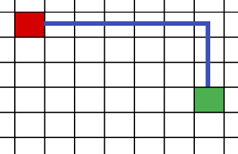                       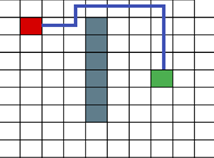

Este algoritmo A* posee una estructura inteligente que lo hace mas eficiente que muchos otros algoritmos, es por eso que su uso es comun cuando se habla de graph traversals y path-finding. 

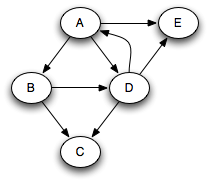

## ¿Cómo funciona?

Si tenemos un escenario compuesto de cuadros, cada celda poseerá un ID para identificarla, luego para utilizar el algoritmo se le otorgaran tres características:
* G: Representa el costo que tiene moverse desde el punto inicial a la celda.
* H: Representa el costo que tiene moverse desde el punto Final a la celda. Este valor h también se conoce como valor heurístico ya que es una estimación y no representa el valor ideal.

* F=H+G

La forma en la que el algoritmo determina el camino es por medio del valor F, El algoritmo selecciona las celdas con menor valor F y se desplaza a esta, este proceso se repite hasta llegar al objetivo deseado. 


# Ejemplo 

Tenemos un punto de partida (rojo), un objetivo(verde) y un obstáculo(gris).

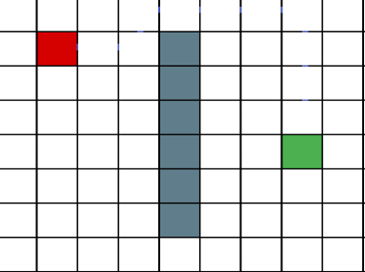


      

Colocamos a cada celda su respectivo F, G, H. Si solo tenemos en cuenta movimientos verticales y horizontales cada uno con valor de 10 se representara de la siguiente forma.

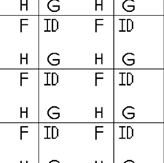 -> 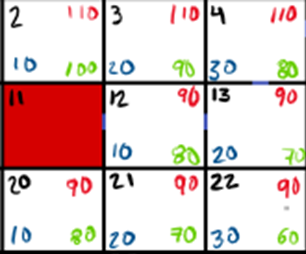

Teniendo esto el algoritmo trabajara con lista abierta, lista cerrada, posición actual.

Aplicado al ejercicio tendriamos: 
* Lista abierta: 2,12,20
* Lista cerrada: 11
* Posición actual: 11

!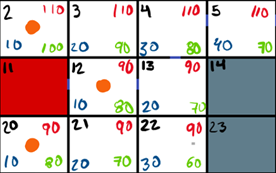

Luego se selecciona la celda con menor F. Por lo que la nueva posición actual corresponde a 12 y 20. Siguiendo el algoritmo este guardara en la lista abierta los nuevos nodos por analizar, en este caso las celdas que rodean a 12 y 20, desapues el algoritmo se desplaza al menor f encontrado e ignora las celdas que corresponde a obstáculos, por ultimo guardará en la lista cerrada las celdas que requieran menos movimientos para desplazarse al nuevo f menor.

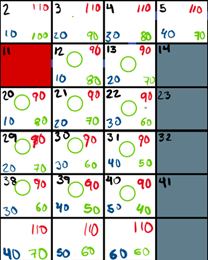 ->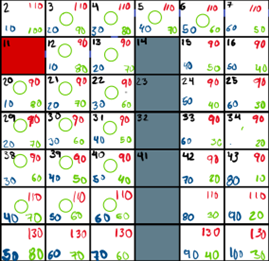-->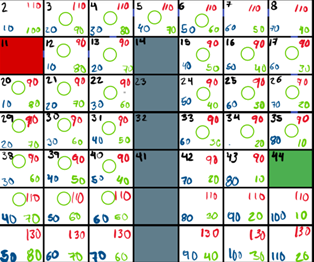

Una vez que el algoritmo llega a la celda deseada, el camino más corto será el que pase por las celdas que se encuentren en la lista cerrada. 

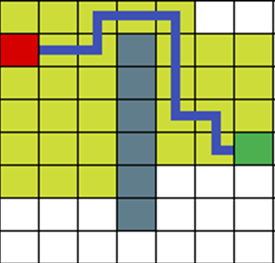

## Uso en Godot

Para este proyecto se usara godot engine 3.5 para poner en practica el algoritmo 

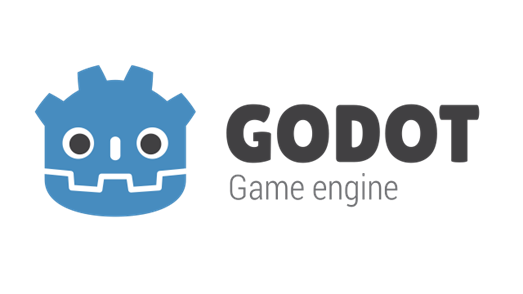

Para implementarlo en godot utilizaremos dos entidades cada una con su respectivo codigo. 


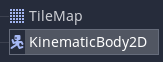

* TileMap representa el mapa en forma de rejilla. 
* KinematicBody2D será la entidad que recorra el mapa. 

### TileMap

Dibujando un mapa en el TileMap le insertamos el siguiente código 

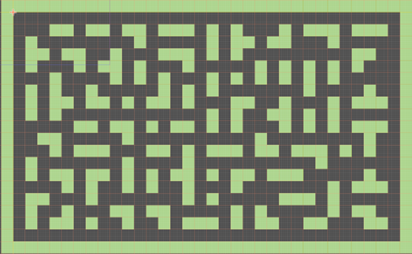

Indica el tamaño del mapa.

In [ ]:
export(Vector2) var map_size = Vector2.ONE * 256


Se crean las variables que representan el inicio y final del camino.

In [ ]:
var path_start_position = Vector2() setget _set_path_start_position
var path_end_position = Vector2() setget _set_path_end_position

Setters para el inicio y final del camino.

In [ ]:
func _set_path_start_position(value):
	if value in obstacles:
		return
	if is_outside_map_bounds(value):
		return

	set_cell(path_start_position.x, path_start_position.y, -1)
	set_cell(value.x, value.y, 1)
	path_start_position = value
	if path_end_position  != path_start_position:
		_recalculate_path()


func _set_path_end_position(value):
	if value in obstacles:
		return
	if is_outside_map_bounds(value):
		return

	set_cell(path_start_position.x, path_start_position.y, -1)
	set_cell(value.x, value.y, 2)
	path_end_position = value
	if path_start_position != value:
		_recalculate_path()


Esta variable almacena las celdas ocupadas por la imagen que representa el muro.

In [ ]:
onready var obstacles = get_used_cells_by_id(5)

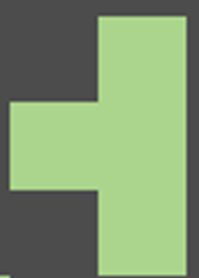

Crea un nodo de la clase Astar de godot

In [ ]:
onready var astar_node = AStar.new()

La funcion astar_add_walkable_cells recorre todas las celdas dentro del límite del mapa y las añade al astar_node exceptuando los obstáculos.

In [ ]:
func astar_add_walkable_cells(obstacle_list = []):
	var points_array = []
	for y in range(map_size.y):
		for x in range(map_size.x):
			var point = Vector2(x, y)
			if point in obstacle_list:
				continue

			points_array.append(point)
			#La clase AStar hace referencia a puntos con índices.
 			#El uso de una función para calcular el índice a partir de las coordenadas de un punto
  			#garantiza que siempre obtengamos el mismo índice con el mismo punto de entrada.
			var point_index = calculate_point_index(point)
			# AStar funciona para 2D y 3D por lo que hay que convertir a Vector3
			
			astar_node.add_point(point_index, Vector3(point.x, point.y, 0.0))
	return points_array

Una vez se obtienen todos los nodos hay que conectarlos, gracias a la clase Astar los puntos no tienen que estar necesariamente en una cuadricula. 

Para cada celda verificamos las celdas que la rodean si se encuentra en el mapa y no es un obstaculo conecta el punto actual con esta.  

In [ ]:
func astar_connect_walkable_cells(points_array):
	for point in points_array:
		var point_index = calculate_point_index(point)
		
		var points_relative = PoolVector2Array([
			point + Vector2.RIGHT,
			point + Vector2.LEFT,
			point + Vector2.DOWN,
			point + Vector2.UP,
		])
		for point_relative in points_relative:
			var point_relative_index = calculate_point_index(point_relative)
			if is_outside_map_bounds(point_relative):
				continue
			if not astar_node.has_point(point_relative_index):
				continue
            astar_node.connect_points(point_index, point_relative_index, false)
			

astar_node.connect_points posee tres argumentos al ser ultimo argumento false se establese un camino unidireccional.


la funcion  func _recalculate_path redibuja el camino.

In [ ]:
func _recalculate_path():
	clear_previous_path_drawing()
	var start_point_index = calculate_point_index(path_start_position)
	var end_point_index = calculate_point_index(path_end_position)
	
	_point_path = astar_node.get_point_path(start_point_index, end_point_index)
	
	update()

La funcion get_astar_path  recibe un punto de inicio y uno llegada, luego usando las funciones creadas previamente retorna el camino a seguir.

In [ ]:
func get_astar_path(world_start, world_end):
	self.path_start_position = world_to_map(world_start)
	self.path_end_position = world_to_map(world_end)
	_recalculate_path()
	var path_world = []
	for point in _point_path:
		var point_world = map_to_world(Vector2(point.x, point.y)) + _half_cell_size
		path_world.append(point_world)
	return path_world


### KinematicBody2D

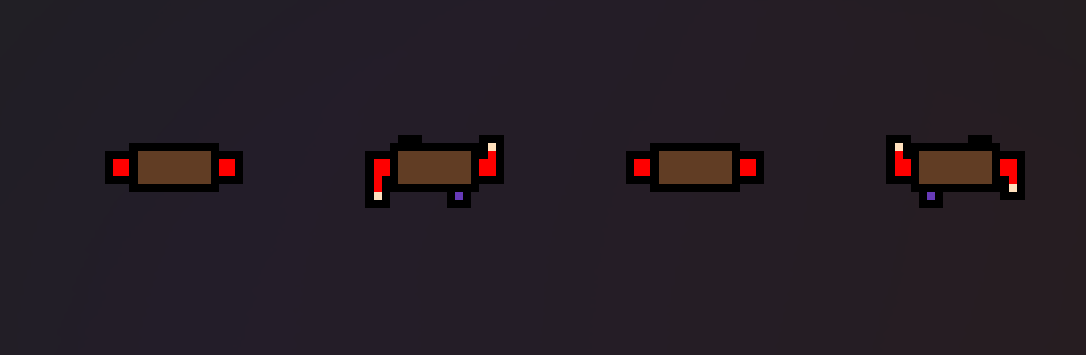

Este nodo poseera dos estados

In [ ]:
enum States { IDLE, FOLLOW }

var _state = States.IDLE

Y las siguientes caracteristicas para determinar  el movimiento 

In [ ]:
const MASS = 10.0
const ARRIVE_DISTANCE = 10.0

export(float) var speed = 110.0

var _path = []
var _target_point_world = Vector2()
var _target_position = Vector2()

var _velocity = Vector2()

Esta funcion recibe el objetivo.

In [ ]:
func _unhandled_input(event):
	
	if f:
		var Player = get_parent().get_node("Limon").get_position()	
		if Input.is_key_pressed(KEY_SHIFT):
			global_position = Player
		else:
			_target_position = Player
		_change_state(States.FOLLOW)

Esta funcion recibe un punto e indica el movimiento a este.

In [ ]:
func _move_to(world_position):
	var desired_velocity = (world_position - position).normalized() * speed
	var steering = desired_velocity - _velocity
	_velocity += steering / MASS
	position += _velocity * get_process_delta_time()
	rotation = _velocity.angle()
	return position.distance_to(world_position) < ARRIVE_DISTANCE


Luego se tiene la funcion que cambia el estado del ente de IDLE  a FOLLOW y recibe el camino a seguir de la funcion get_astar_path del TileMap.

In [ ]:
unc _change_state(new_state):
	
	if new_state == States.FOLLOW :
		_path = get_parent().get_node("TileMap").get_astar_path(position, _target_position)
		if not _path or len(_path) == 1:
			_change_state(States.IDLE)
			return
		
		_target_point_world = _path[1]
	_state = new_state

Por ultimo tenemos la funcion que usa  _move_to dandole el objetivo y luego cambia el estado del ente a IDLE cuando termine el recorrido.  

In [ ]:
func _process(_delta):
	if _state != States.FOLLOW:
		return
	var _arrived_to_next_point = _move_to(_target_point_world)
	if _arrived_to_next_point:
		_path.remove(0)
		if len(_path) == 0:
			_change_state(States.IDLE)
			return
		_target_point_world = _path[0]

### Resultado

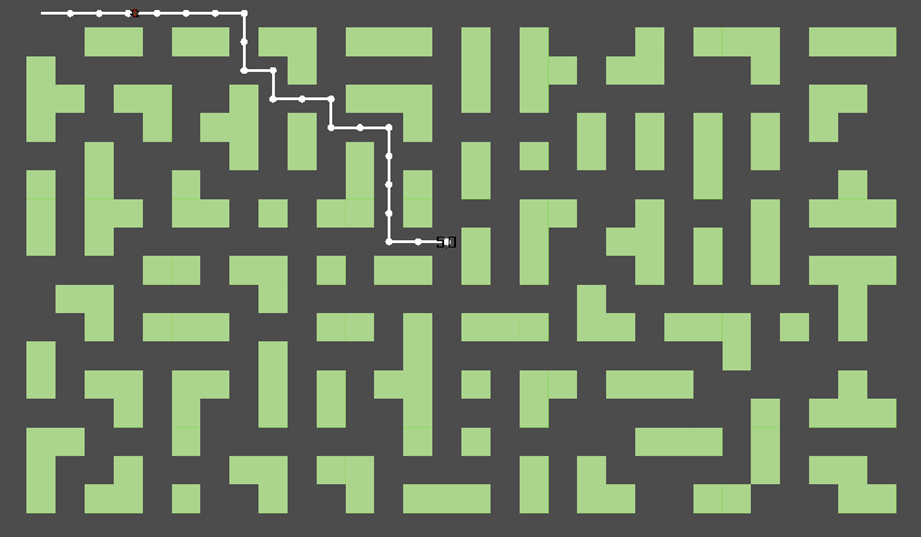

Como resultado obtenemos que nuestro ente se desplaza ruta optima hasta su objetivo y agregando una función que dibuje el camino podemos ver de mejor forma el funcionamiento del algoritmo que sigue.